# Medical Education Dataset Analysis Report

This notebook provides a comprehensive analysis of a medical education dataset, including descriptive statistics, group comparisons, and statistical testing. The notebook is structured for clarity and readability, making it suitable for conversion to a PDF report.

### Tasks to Complete
- **Review the descriptive statistics of the sample:**
    - Characteristics such as year of training, age, gender, race, and prior education.
    - Mean scores of PPOS and PPOS subscales.

- **Perform comparisons of PPOS and subscales:**
    - By year of training.
    - By gender (Male/Female).
    - By prior education (e.g., CEGEP, Bachelors, Graduate).
    - By intended specialization:
        - Primary vs. non-primary care.
        - Surgical vs. non-surgical.

- **Clean and preprocess the dataset:**
    - Ensure all columns are renamed appropriately using the column_rename dictionary.
    - Drop unnecessary columns (gender_other, race_other).

- **Explore and visualize the data:**
    - Generate plots to visualize the distribution of key variables (e.g., age, PPOS scores).
    - Create comparison plots for PPOS and subscales based on the specified categories.

- **Document findings and insights:**
    - Summarize the key characteristics of the sample.
    - Highlight significant differences in PPOS and subscales across the specified categories.



In [239]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import re
from unidecode import unidecode
from IPython.display import display, HTML
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import skew, skewtest

# Set seaborn theme for consistent plots
sns.set_theme(style="darkgrid", palette="bright")

# Display options for wide tables
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None) 

# Custom CSS for scrollable tables in notebook/PDF
display(
    HTML(
        """
<style>
.scroll-table {
    display: block;
    overflow-x: auto;
    white-space: nowrap;
}
</style>
        """
    )
)

## 2. Load and Preprocess Data

The dataset is loaded from an Excel file. We rename columns for consistency and easier access.

In [240]:
column_rename = {
    "Record ID": "record_id",
    "Timepoint": "timepoint",
    "PPOS": "ppos",
    "PPOS-S": "ppos_s",
    "PPOS-C": "ppos_c",
    "Age:": "age",
    "Gender Identity": "gender",
    "Other: Specify": "gender_other",
    "How proficient are you in French?": "french_proficiency",
    "How proficient are you in English?": "english_proficiency",
    "Do you speak any other languages? Please specify your proficiency (Fluent, Moderate, Basic). Please answer in format: [Language, Proficiency] for all languages.    ": "other_languages",
    "Please specify if other level of training": "other_training",
    "Please list all previous education you have completed (e.g., CEGEP, BSc, MSc, PHD, other professional certification). Please answer in format [degree, year of completion]": "prior_education",
    "Site of study": "site_of_study",
    "Do you have an intended specialization (including Family Medicine)?": "intended_specialization",
    "What is your intended specialization?": "specialty",
    # Cultural identity columns
    "Other (Please specify):": "race_other",
    "Which Cultural Identities do you identify as? (Select that apply)   (choice=Black/African Canadian)": "cultural_black",
    "Which Cultural Identities do you identify as? (Select that apply)   (choice=East Asian (e.g., Chinese, Japanese, Korean))": "cultural_east_asian",
    "Which Cultural Identities do you identify as? (Select that apply)   (choice=Indigenous (First Nations, Métis, Inuit))": "cultural_indigenous",
    "Which Cultural Identities do you identify as? (Select that apply)   (choice=Middle Eastern/North African (e.g., Arab, Persian))": "cultural_middle_eastern",
    "Which Cultural Identities do you identify as? (Select that apply)   (choice=Latin American (e.g., Mexican, Brazilian, Coloumbian))": "cultural_latin_american",
    "Which Cultural Identities do you identify as? (Select that apply)   (choice=South Asian (e.g., Indian, Bangladeshi, Sri Lankan))": "cultural_south_asian",
    "Which Cultural Identities do you identify as? (Select that apply)   (choice=South East Asian (e.g. Filipino, Vietnamese, Thai))": "cultural_southeast_asian",
    "Which Cultural Identities do you identify as? (Select that apply)   (choice=White/Caucasian)": "cultural_white",
    "Which Cultural Identities do you identify as? (Select that apply)   (choice=Other (please specify))": "cultural_other",
}

df = pd.read_excel("MSHumanism_CleanQuantData_250625_AC.xlsx", sheet_name="Full Data")
df = df.loc[:, ~df.columns.str.contains("^Unnamed")].rename(columns=column_rename)
df['prior_education'] = df["prior_education"].apply(unidecode)

## 3. Clean and Transform Columns

We perform several cleaning steps to prepare the data for analysis.

**Drop unnecessary columns:**  
Columns with zero or non-essential data, such as `gender_other` and `race_other`, are removed to simplify the dataset.

In [241]:
# Drop columns with 0 or non-essential data
df = df.drop(columns=["gender_other", "race_other"])

**Handle multi-select race/cultural identity columns:**  
Participants may select multiple cultural identities. We convert these columns to boolean values for easier analysis.

In [242]:
def checked(row):
    return row.lower() == "checked"

checked_cols = [
    "cultural_black",
    "cultural_east_asian",
    "cultural_indigenous",
    "cultural_middle_eastern",
    "cultural_latin_american",
    "cultural_south_asian",
    "cultural_southeast_asian",
    "cultural_white",
    "cultural_other",
]
if df[checked_cols[0]].dtype != "bool":
    df[checked_cols] = df[checked_cols].map(checked)

**Create degree indicator columns:**  
We generate boolean columns indicating whether a participant has completed certain degrees (DEC/CEGEP, Bachelors, Masters, Doctorate) based on their prior education text.

In [243]:
# Create degree indicator columns
df['has_dec'] = df['prior_education'].str.lower().str.replace(".", "").str.contains('dec|cegep|bac|cegep')
df['has_bsc'] = df['prior_education'].str.lower().str.replace(".", "").str.contains('bsc|undergrad|b.asc|b.sc|bs|ba|bachelor|bkin|beng|b')
df['has_msc'] = df['prior_education'].str.lower().str.replace(".", "").str.contains('msc|graduate|ma')
df['has_doc'] = df['prior_education'].str.lower().str.replace(".", "").str.contains('phd|pharmd|pharm.d|llm')

**Assign highest degree:**  
We create a new column indicating the highest degree obtained by each participant.

In [244]:
def get_highest_degree(row):
    if row['has_doc']:
        return 'Doctorate'
    elif row['has_msc']:
        return 'Masters'
    elif row['has_bsc']:
        return 'Bachelors'
    elif row['has_dec']:
        return 'DEC/CEGEP'
    else:
        return 'None'

df['highest_degree'] = df.apply(get_highest_degree, axis=1)

**Standardize year of training column:**  
We clean and standardize the `timepoint` column to ensure consistent year-of-training labels.

In [245]:
def clean_timepoint(s):
    s = s.upper().strip()
    matches = re.match(r"M\d+", s)
    return matches.group() if matches is not None else None

df["timepoint"] = df["timepoint"].map(clean_timepoint)

**Merge specialization columns:**  
We join additional columns indicating primary care, non-primary care, surgical, and non-surgical specialization from a secondary sheet.

In [246]:
df_speciality = pd.read_excel('MSHumanism_CleanQuantData_250625_AC.xlsx', sheet_name='specialty')
df_speciality.columns = df_speciality.columns.str.lower().str.replace(" ", "_")
df_speciality = df_speciality.loc[:, ['record_id','primary_care', 'non_primary_care', 'surgical', 'non_surgical']]

if "non_surgical" not in df.columns: 
    df = df.join(df_speciality.set_index('record_id'), on='record_id', how='left')

# Convert specialization columns to boolean
speciality_cols = ['primary_care', 'non_primary_care', 'surgical', 'non_surgical']
df[speciality_cols] = df[speciality_cols] == 1

## 4. Display First Rows of Cleaned Data

Preview of cleaned dataset (first 10 rows).  
The table is scrollable for wide datasets.

In [247]:
HTML(df.head(10).to_html(max_rows=None, max_cols=None, classes="scroll-table"))

,record_id,timepoint,ppos,ppos_s,ppos_c,age,gender,cultural_black,cultural_east_asian,cultural_indigenous,cultural_middle_eastern,cultural_latin_american,cultural_south_asian,cultural_southeast_asian,cultural_white,cultural_other,french_proficiency,english_proficiency,other_languages,other_training,prior_education,site_of_study,intended_specialization,specialty,has_dec,has_bsc,has_msc,has_doc,highest_degree,primary_care,non_primary_care,surgical,non_surgical
0,1,M2,88,40,48,21,Female,False,False,False,True,False,False,False,False,False,Fluent,Fluent,"Spanish (moderate), Arab (moderate)",NaN,"CEGEP, 2022",Montreal,Yes,Internal medicine,True,False,False,False,DEC/CEGEP,False,True,False,True
1,2,M4,75,29,46,42,Female,False,False,False,False,False,True,False,False,False,Fluent,Fluent,"Hindi, Punjabi, Urdu",NaN,Graduate studies in Experimental Medicine,Montreal,No,NaN,False,False,True,False,Masters,False,False,False,False
2,3,M3,76,38,38,30,Male,False,False,False,True,False,False,False,False,False,Moderate,Fluent,"Arabic, proficient",NaN,"Bsc, jd, llm",Montreal,Yes,Dermatology,False,True,False,True,Doctorate,False,True,False,True
3,5,M2,76,42,34,25,Male,False,False,False,False,False,False,False,True,False,Moderate,Fluent,none,NaN,"CEGEP, Bsc, Msc",Montreal,Yes,internal medicine - maybe medical oncology,True,True,True,False,Masters,False,True,False,True
4,7,M3,61,33,28,27,Male,True,False,False,False,False,False,False,False,False,Fluent,Fluent,Basic Japanese,NaN,BSc Human Kinetics 2020 BSc Translational and Molecular Medicine 2022,Montreal,Yes,Anesthesia,False,True,True,False,Masters,False,True,False,True
5,8,M1,72,35,37,18,Female,False,False,False,False,False,False,True,False,False,Fluent,Fluent,"Vietnamese, fluent",NaN,CEGEP - 2020 BSc - 2022,Montreal,Yes,Ophthalmology,True,True,False,False,Bachelors,False,True,True,False
6,10,M3,70,27,43,33,Male,False,False,False,False,False,False,False,True,False,Fluent,Fluent,Spanish,NaN,Undergrad,Montreal,Yes,Fam + ER,False,True,False,False,Bachelors,True,False,False,True
7,11,M2,75,32,43,29,Female,False,False,False,False,False,False,False,False,True,Fluent,Fluent,Armenian Spanish,NaN,"Marianopolis, 2014 Bsc, 2017, 2020 Msc, 2023",Montreal,No,NaN,False,True,True,False,Masters,False,False,False,False
8,13,M3,79,35,44,23,Female,False,True,False,False,False,False,False,False,False,Fluent,Fluent,Mandarin -fluent,NaN,Cegep 2021,Montreal,Yes,Internal medicine,True,False,False,False,DEC/CEGEP,False,True,False,True
9,14,M3,67,31,36,27,Female,False,False,False,False,False,False,False,True,False,Fluent,Fluent,"Anglais, intermédiaire",NaN,"Cegep, BSc",Outaouais,Yes,"Pediatrie, chirurgie plastique, médecine familiale",True,True,False,False,Bachelors,False,False,False,False


## 5. Descriptive Statistics and Demographics

Descriptive statistics for year of training, age, gender, race/cultural identity, prior education, and PPOS scores.  
This section summarizes the key characteristics of the sample.

In [248]:
df.describe()

,record_id,ppos,ppos_s,ppos_c,age
count,138.000000,138.000000,138.000000,138.000000,138.000000
mean,107.485507,50.615942,27.963768,22.652174,25.637681
std,65.759153,11.087787,4.370454,8.138089,4.197570
min,1.000000,34.000000,17.000000,11.000000,18.000000
25%,44.250000,44.000000,25.000000,18.000000,23.000000
50%,111.500000,48.000000,27.000000,21.000000,25.000000
75%,168.750000,52.000000,30.000000,24.000000,27.750000
max,214.000000,88.000000,42.000000,49.000000,43.000000


## 6. Visualize Year of Training Distribution

Distribution of participants by year of training.

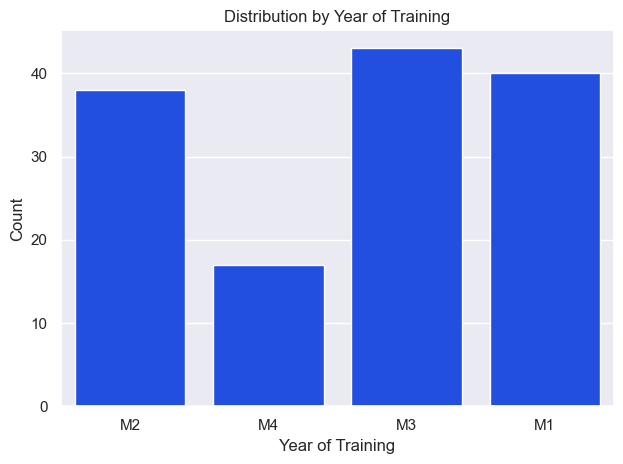

timepoint
M3    43
M1    40
M2    38
M4    17
Name: count, dtype: int64

In [249]:
# Plot the distribution of year of training (timepoint)
sns.countplot(df, x='timepoint')
plt.title("Distribution by Year of Training")
plt.xlabel("Year of Training")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

df['timepoint'].value_counts()

## 7. Visualize Gender Distribution

Distribution of participants by gender.

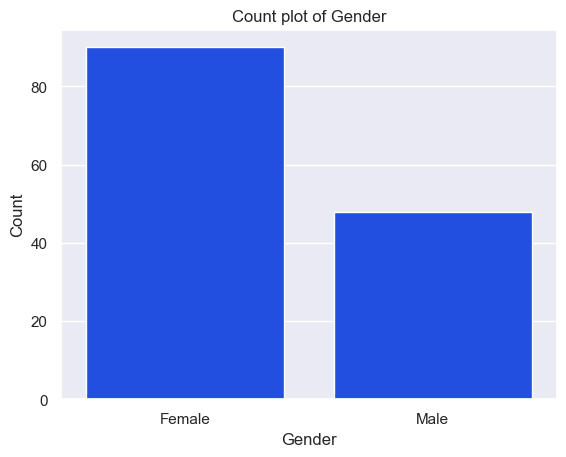

gender
Female    90
Male      48
Name: count, dtype: int64

In [250]:
# Plot the distribution of gender
ax = sns.countplot(df, x="gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Count plot of Gender")
plt.show()

df['gender'].value_counts()

## 8. Visualize Age Distribution

Age distribution of participants with mean and standard deviation.

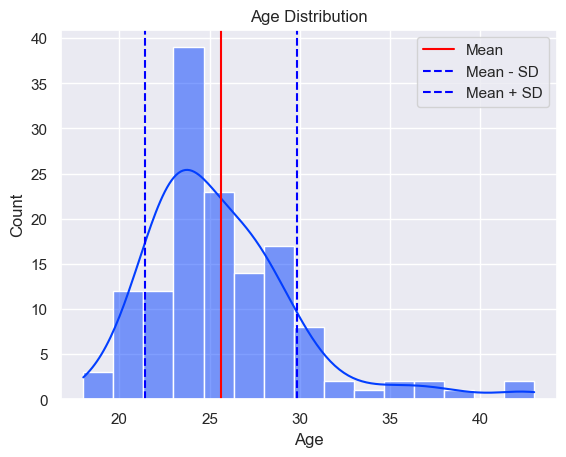

count    138.000000
mean      25.637681
std        4.197570
min       18.000000
max       43.000000
Name: age, dtype: float64

In [251]:
drop_desc = ["25%", "50%", "75%"]

age_mean = df['age'].mean()
age_std = df['age'].std()
sns.histplot(df['age'], bins=15, kde=True)
plt.title('Age Distribution')
plt.axvline(age_mean, c='red', label='Mean')
plt.axvline(age_mean - age_std, c = "blue" , linestyle="--", label='Mean - SD')
plt.axvline(age_mean + age_std, c = "blue" , linestyle="--", label='Mean + SD')
plt.xlabel('Age')
plt.legend()
plt.show()

df["age"].describe().drop(drop_desc)

## 9. Visualize Race/Cultural Identity Distribution

Distribution of self-identified cultural identities.

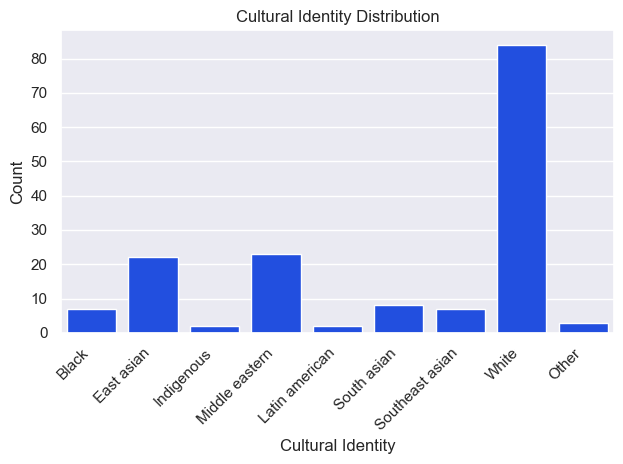

,Cultural Identity,Count
7,White,84
3,Middle eastern,23
1,East asian,22
5,South asian,8
0,Black,7
6,Southeast asian,7
8,Other,3
2,Indigenous,2
4,Latin american,2


In [252]:
race_cols = [col for col in df.columns if col.startswith('cultural_')]

cultural_counts = df[race_cols].sum().reset_index()
cultural_counts.columns = ['Cultural Identity', 'Count']

cultural_counts['Cultural Identity'] = cultural_counts['Cultural Identity'].str.replace("cultural_","").str.replace('_', " ").str.capitalize()
sns.barplot(data=cultural_counts, x='Cultural Identity', y='Count')
plt.title('Cultural Identity Distribution')
plt.ylabel('Count')
plt.xlabel('Cultural Identity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

cultural_counts.sort_values(by="Count", ascending=False)

## 10. Visualize Prior Education and Degree Distribution

Distribution of highest degree and prior education.

In [253]:
edu_cols = [col for col in df.columns if col.startswith('has_')]
edu_counts = df[edu_cols].sum().reset_index()
edu_counts.columns = ['Education', 'Count']
edu_counts['Education'] = edu_counts["Education"].str.upper().str.split("_").str[1]

# Uncomment below to plot if desired
# sns.barplot(edu_counts, x='Education', y='Count')
# plt.title("Count of previous degrees")
# plt.xlabel("Degree")
# plt.tight_layout()
# plt.show()

# edu_counts

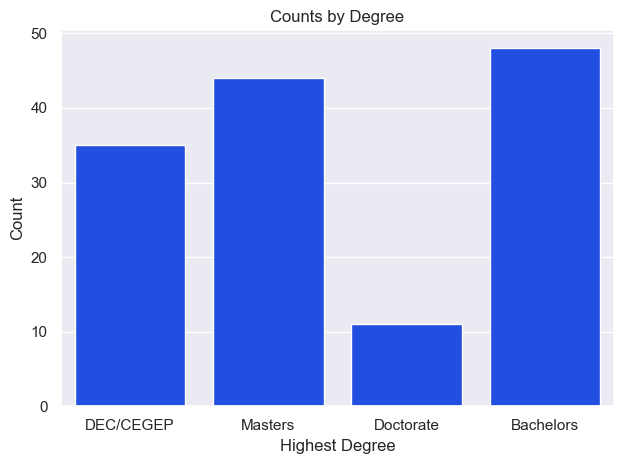

highest_degree
Bachelors    48
Masters      44
DEC/CEGEP    35
Doctorate    11
Name: count, dtype: int64

In [254]:
# Plot the distribution of highest degree
sns.countplot(df, x='highest_degree')
plt.title("Counts by Degree")
plt.xlabel("Highest Degree")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

df['highest_degree'].value_counts()

## 11. Visualize PPOS and Subscale Score Distributions

Distribution of PPOS and subscale scores (PPOS, PPOS-S, PPOS-C).

**PPOS**: Patient-Practitioner Orientation Scale, a measure of attitudes toward patient-centeredness.  
**PPOS-S**: Sharing subscale.  
**PPOS-C**: Caring subscale.

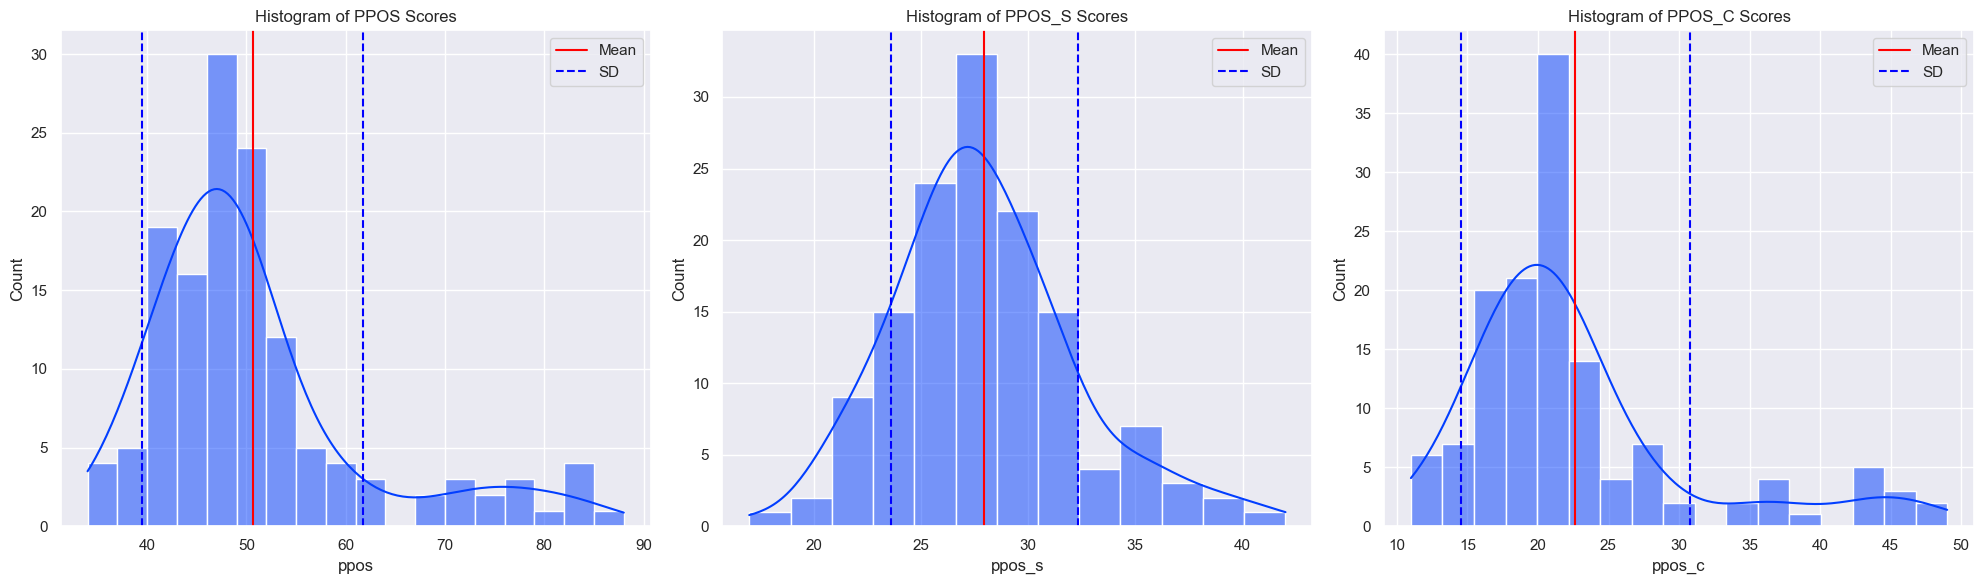

In [255]:
score_cols = ["ppos", "ppos_s", "ppos_c"]
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, col in zip(axes, score_cols):
    sns.histplot(df, x=col, ax=ax, kde=True)
    mean = df[col].mean()
    std = df[col].std()
    ax.axvline(mean, color="red", label="Mean")
    ax.axvline(mean + std, color="blue", linestyle="--")
    ax.axvline(mean - std, color="blue", linestyle="--", label="SD")
    ax.set_title(f"Histogram of {col.upper()} Scores")
    ax.legend()

plt.tight_layout()
plt.show()

## 12. Compare PPOS and Subscales by Year of Training

Comparison of PPOS and subscale scores by year of training.

Below, we show group statistics and boxplots for each year.

In [256]:
# Group statistics by year of training
for col in score_cols:
    print(col.upper() + '\n' + '--'*30)
    print(df.groupby('timepoint')[col].describe().drop(drop_desc+['count'], axis=1))
    print()

PPOS
------------------------------------------------------------
                mean        std   min   max
timepoint                                  
M1         50.050000  11.281821  34.0  82.0
M2         50.368421  11.165635  37.0  88.0
M3         52.302326  11.578993  39.0  84.0
M4         48.235294   9.357680  36.0  75.0

PPOS_S
------------------------------------------------------------
                mean       std   min   max
timepoint                                 
M1         28.100000  4.354779  17.0  38.0
M2         27.973684  4.252102  22.0  42.0
M3         28.139535  4.533376  20.0  38.0
M4         27.176471  4.558444  21.0  40.0

PPOS_C
------------------------------------------------------------
                mean       std   min   max
timepoint                                 
M1         21.950000  7.958063  11.0  46.0
M2         22.394737  8.062390  11.0  48.0
M3         24.162791  8.507504  14.0  49.0
M4         21.058824  7.885672  11.0  46.0



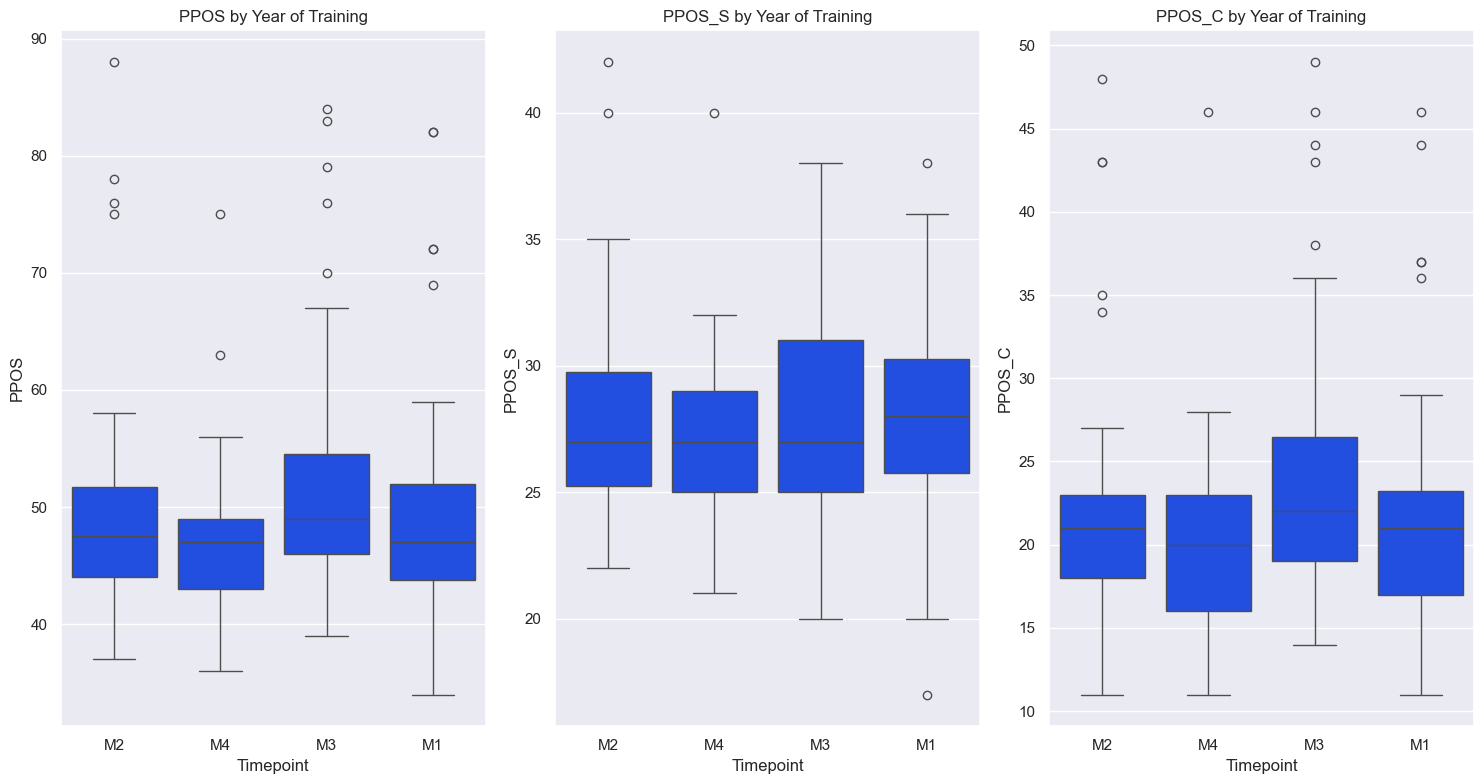

In [257]:
# Boxplots by year of training
_, axes = plt.subplots(1,3, figsize=(15,8))

for col, ax in zip(score_cols, axes):
    sns.boxplot(data=df, x='timepoint', y=col, ax=ax)
    ax.set_title(f"{col.upper()} by Year of Training")
    ax.set_xlabel("Timepoint")
    ax.set_ylabel(col.upper())
    
plt.tight_layout()
plt.show()

## 13. Compare PPOS and Subscales by Highest Degree

Comparison of PPOS and subscale scores by highest degree obtained.

In [258]:
# Group statistics by highest degree
summary = df.groupby('highest_degree')[score_cols].describe()
summary = summary.round(2)
summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
HTML(summary.to_html(max_rows=None, max_cols=None, classes="scroll-table"))

,ppos_count,ppos_mean,ppos_std,ppos_min,ppos_25%,ppos_50%,ppos_75%,ppos_max,ppos_s_count,ppos_s_mean,ppos_s_std,ppos_s_min,ppos_s_25%,ppos_s_50%,ppos_s_75%,ppos_s_max,ppos_c_count,ppos_c_mean,ppos_c_std,ppos_c_min,ppos_c_25%,ppos_c_50%,ppos_c_75%,ppos_c_max
highest_degree,,,,,,,,,,,,,,,,,,,,,,,,
Bachelors,48.0,49.19,9.27,35.0,43.75,47.5,52.00,78.0,48.0,27.77,4.14,17.0,26.0,28.0,29.25,40.0,48.0,21.42,6.78,11.0,17.75,20.5,23.00,43.0
DEC/CEGEP,35.0,52.11,13.98,36.0,44.50,47.0,51.00,88.0,35.0,28.09,4.82,21.0,24.5,27.0,30.50,40.0,35.0,24.03,9.97,11.0,19.00,21.0,22.50,49.0
Doctorate,11.0,49.55,11.35,34.0,42.00,47.0,54.50,76.0,11.0,28.36,4.46,23.0,25.0,29.0,30.50,38.0,11.0,21.18,7.76,11.0,17.00,19.0,24.50,38.0
Masters,44.0,51.25,10.41,40.0,44.75,49.0,53.25,84.0,44.0,27.98,4.36,20.0,25.0,27.0,30.25,42.0,44.0,23.27,8.00,13.0,17.00,21.0,25.25,46.0


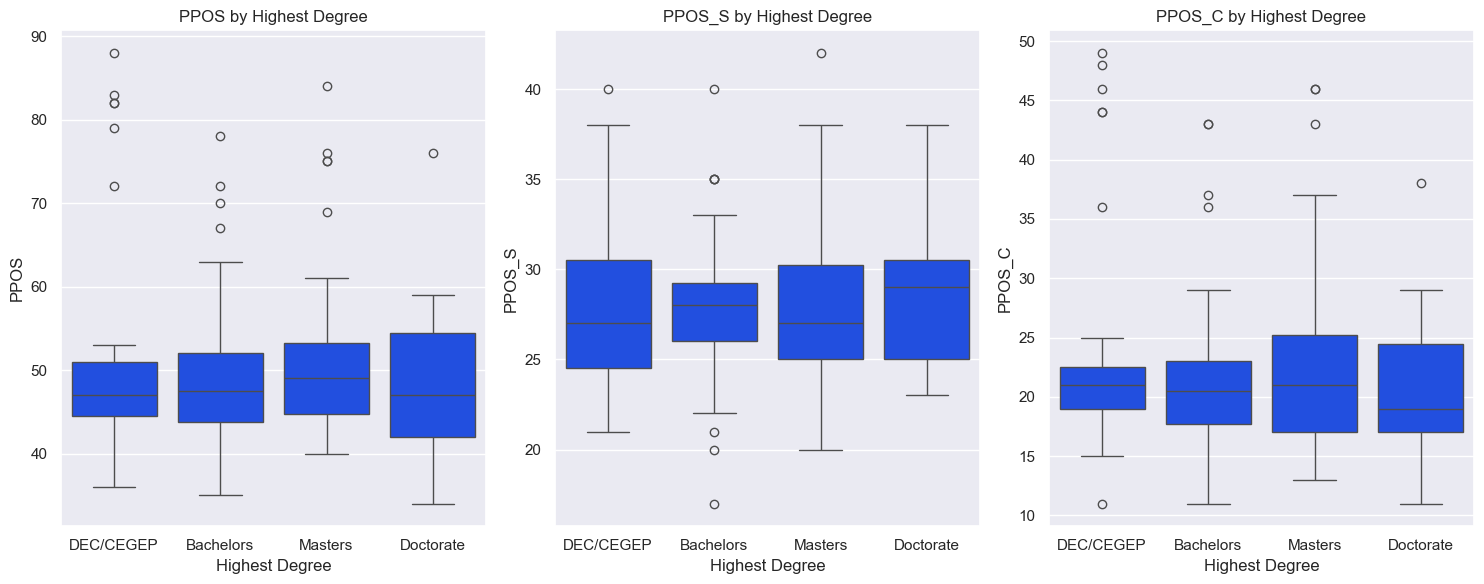

In [259]:
# Boxplots by highest degree
_, axes = plt.subplots(1,3, figsize=(15,6))

for col, ax in zip(score_cols, axes):
    sns.boxplot(data=df, x='highest_degree', y=col, order=['DEC/CEGEP', 'Bachelors', 'Masters', 'Doctorate'], ax=ax)
    ax.set_title(f"{col.upper()} by Highest Degree")
    ax.set_xlabel("Highest Degree")
    ax.set_ylabel(col.upper())

plt.tight_layout()
plt.show()

## 14. Compare PPOS and Subscales by Gender

Comparison of PPOS and subscale scores by gender.

In [260]:
# Group statistics by gender
summary = df.groupby('gender')[score_cols].describe()
summary = summary.round(2)
summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
HTML(summary.to_html(max_rows=None, max_cols=None, classes="scroll-table"))

,ppos_count,ppos_mean,ppos_std,ppos_min,ppos_25%,ppos_50%,ppos_75%,ppos_max,ppos_s_count,ppos_s_mean,ppos_s_std,ppos_s_min,ppos_s_25%,ppos_s_50%,ppos_s_75%,ppos_s_max,ppos_c_count,ppos_c_mean,ppos_c_std,ppos_c_min,ppos_c_25%,ppos_c_50%,ppos_c_75%,ppos_c_max
gender,,,,,,,,,,,,,,,,,,,,,,,,
Female,90.0,50.09,11.38,34.0,43.0,47.0,52.00,88.0,90.0,27.82,4.25,17.0,25.0,27.5,30.0,40.0,90.0,22.27,8.38,11.0,17.00,20.5,23.75,49.0
Male,48.0,51.60,10.56,36.0,46.0,49.0,52.25,84.0,48.0,28.23,4.63,20.0,26.0,27.0,31.0,42.0,48.0,23.38,7.71,11.0,18.75,21.5,24.25,46.0


## 15. Compare PPOS and Subscales by Specialization (Primary/Non-Primary, Surgical/Non-Surgical)

Comparison of PPOS and subscale scores by intended specialization (primary care, non-primary care, surgical, non-surgical).

In [261]:
# Group statistics by specialization
summary = df.groupby(['primary_care', 'non_primary_care'])[score_cols].describe()
summary = summary.round(2)
summary.columns = ['_'.join(col).strip() for col in summary.columns.values]

HTML(summary.to_html(max_rows=None, max_cols=None, classes="scroll-table"))


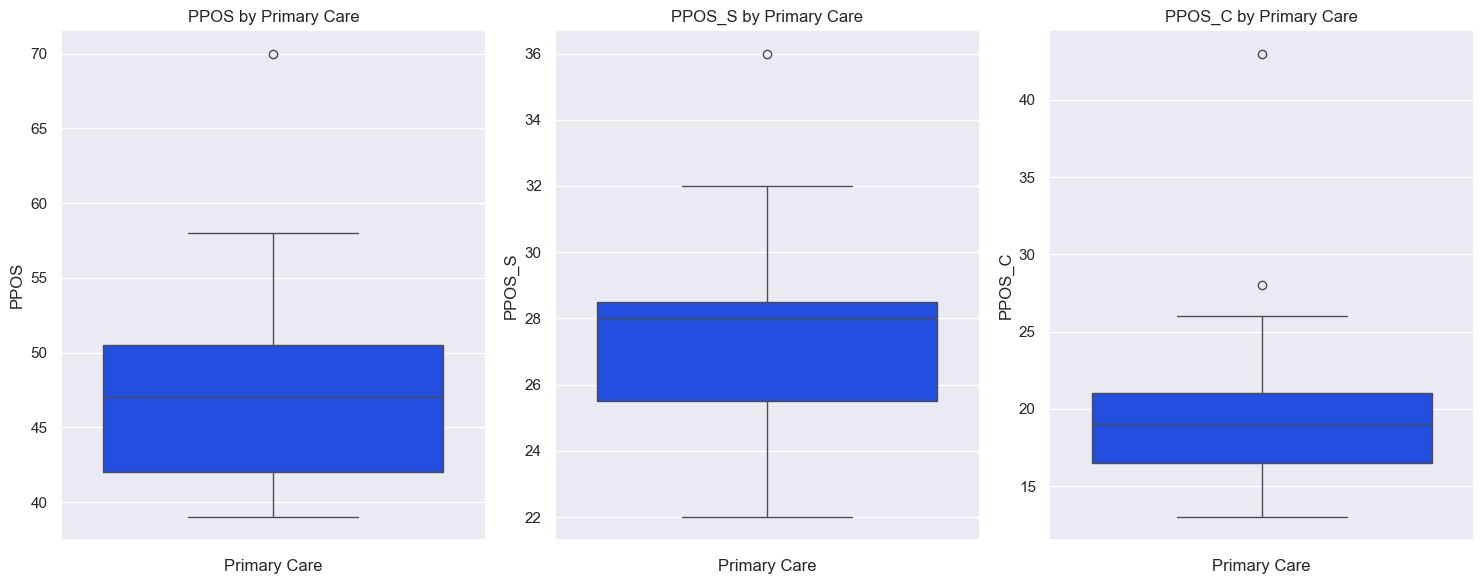

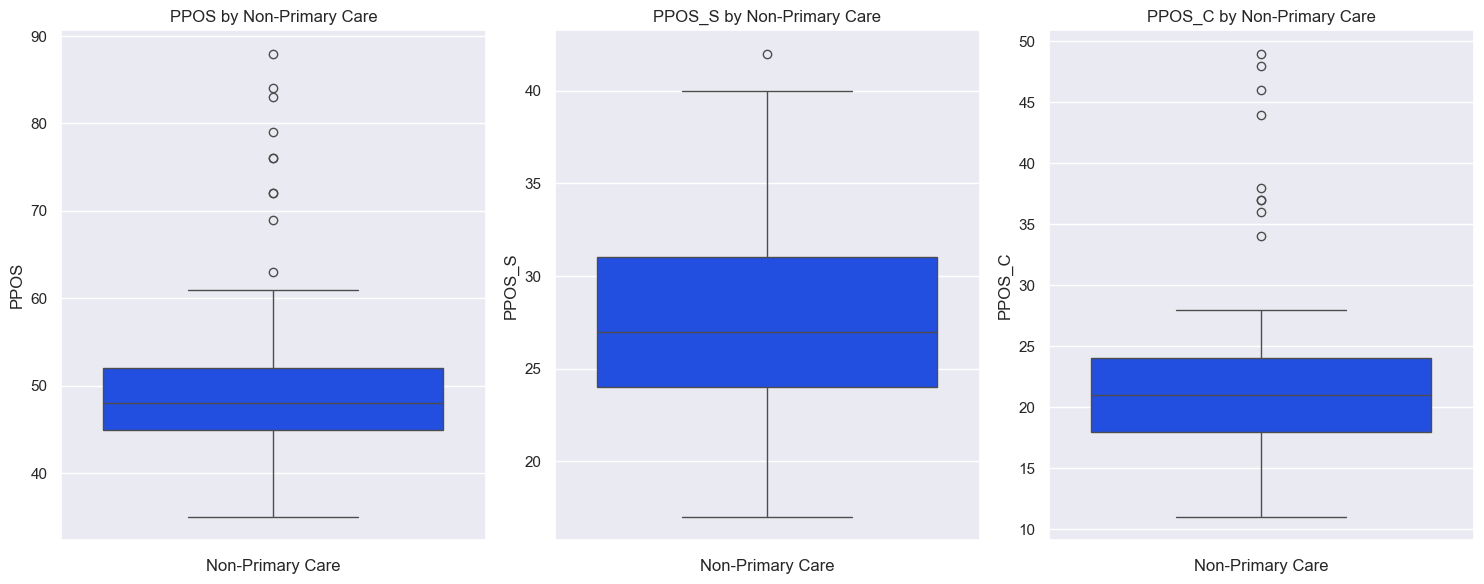

In [262]:
# Boxplots for primary care and non-primary care
_, axes = plt.subplots(1, 3, figsize=(15, 6))
for col, ax in zip(score_cols, axes):
    sns.boxplot(y=df.loc[df['primary_care'], col], ax=ax)
    ax.set_title(f"{col.upper()} by Primary Care")
    ax.set_xlabel("Primary Care")
    ax.set_ylabel(col.upper())
plt.tight_layout()
plt.show()

_, axes = plt.subplots(1, 3, figsize=(15, 6))
for col, ax in zip(score_cols, axes):
    sns.boxplot(y=df.loc[df['non_primary_care'],col], ax=ax)
    ax.set_title(f"{col.upper()} by Non-Primary Care")
    ax.set_xlabel("Non-Primary Care")
    ax.set_ylabel(col.upper())
plt.tight_layout()
plt.show()

In [263]:
# Group statistics by surgical/non-surgical
summary = df.groupby(['surgical', 'non_surgical'])[score_cols].describe()
summary = summary.round(2)
summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
HTML(summary.to_html(max_rows=None, max_cols=None, classes="scroll-table"))

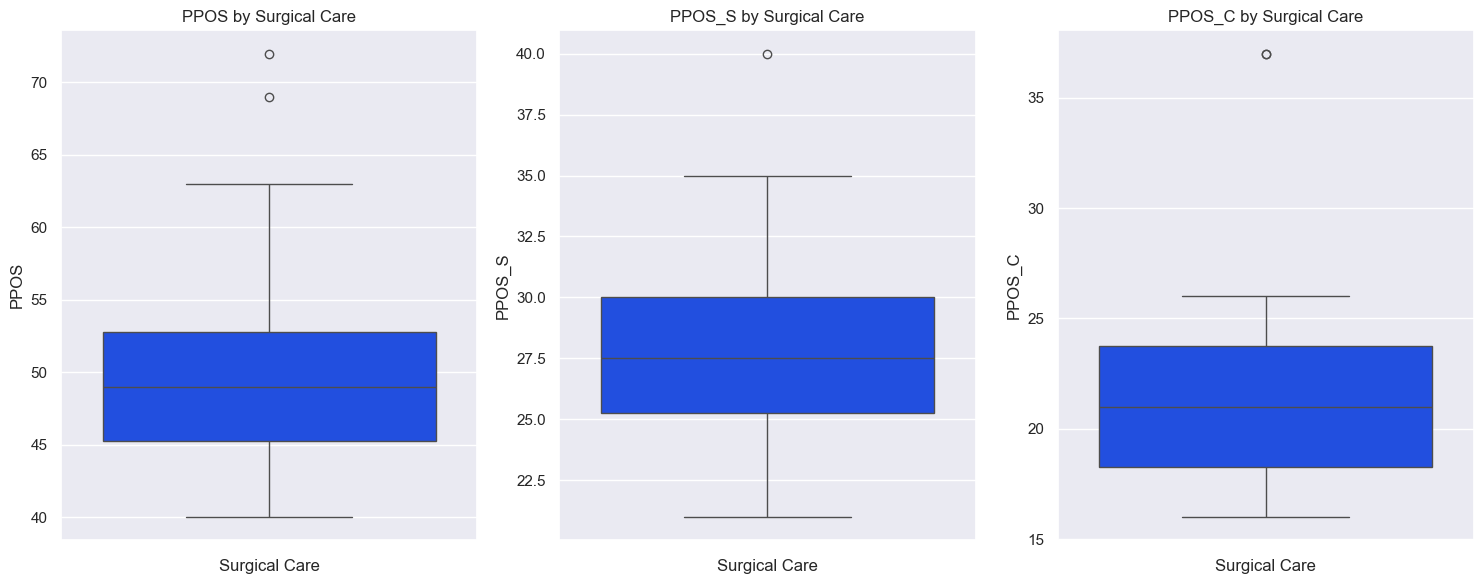

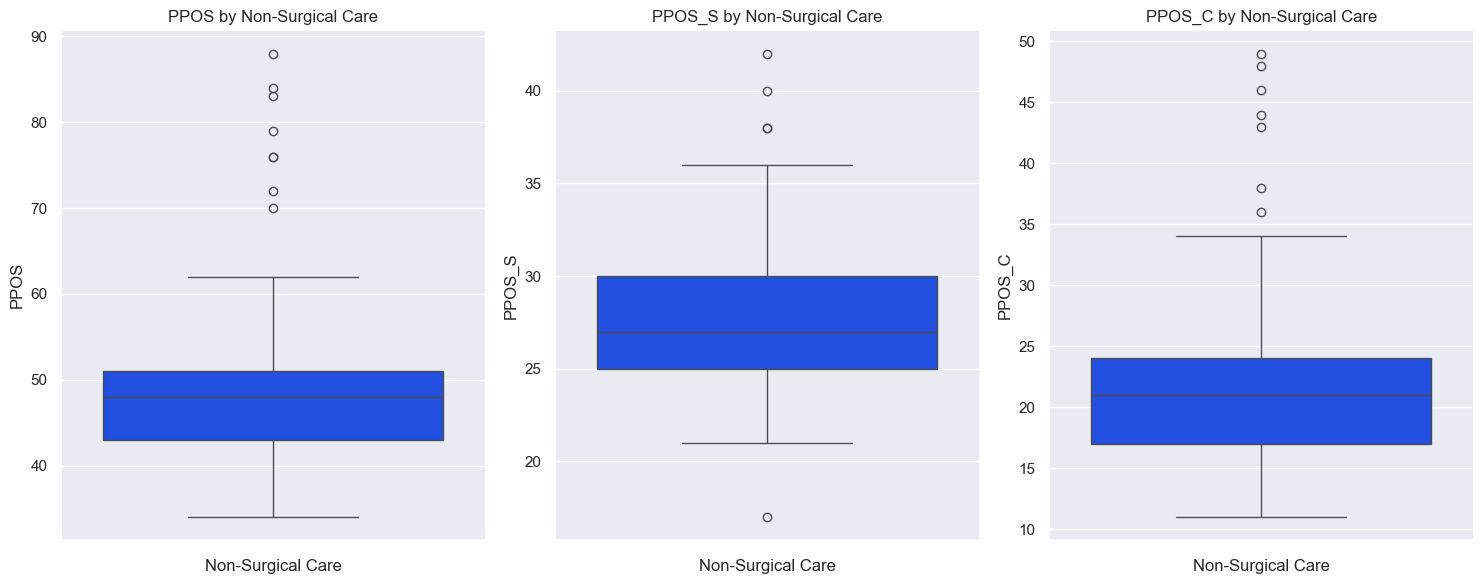

In [264]:
# Boxplots for surgical and non-surgical
_, axes = plt.subplots(1, 3, figsize=(15, 6))
for col, ax in zip(score_cols, axes):
    sns.boxplot(y=df.loc[df['surgical'], col], ax=ax)
    ax.set_title(f"{col.upper()} by Surgical Care")
    ax.set_xlabel("Surgical Care")
    ax.set_ylabel(col.upper())
plt.tight_layout()
plt.show()

_, axes = plt.subplots(1, 3, figsize=(15, 6))
for col, ax in zip(score_cols, axes):
    sns.boxplot(y=df.loc[df['non_surgical'],col], ax=ax)
    ax.set_title(f"{col.upper()} by Non-Surgical Care")
    ax.set_xlabel("Non-Surgical Care")
    ax.set_ylabel(col.upper())
plt.tight_layout()
plt.show()

## 16. Hypothesis Testing for Group Comparisons

Statistical tests (ANOVA, Kruskal-Wallis, Mann-Whitney U, t-test) for group differences in PPOS and subscale scores.

We use non-parametric tests (Kruskal-Wallis, Mann-Whitney U) when data are not normally distributed or are significantly skewed.  
Parametric tests (ANOVA, t-test) are used when assumptions are met.

### Hypothesis testing for PPOS and subscale scores by Timepoint

In [265]:
from scipy.stats import f_oneway, kruskal

# Test for differences in PPOS and subscales by year of training
print('PPOS Kruskal for timepoint')
groups = [df['ppos'][df['timepoint'] == tp] for tp in df['timepoint'].unique()]
h_stat, p_val = kruskal(*groups)
print(f"Kruskal-Wallis: H={h_stat:.2f}, p={p_val:.3f}")

print('PPOS_S ANOVA for timepoint')
groups = [df['ppos_s'][df['timepoint'] == tp] for tp in df['timepoint'].unique()]
f_stat, p_val = f_oneway(*groups)
print(f"ANOVA: F={f_stat:.2f}, p={p_val:.3f}")

print('PPOS_C Kruskal for timepoint')
groups = [df['ppos_c'][df['timepoint'] == tp] for tp in df['timepoint'].unique()]
h_stat, p_val = kruskal(*groups)
print(f"Kruskal-Wallis: H={h_stat:.2f}, p={p_val:.3f}")

PPOS Kruskal for timepoint
Kruskal-Wallis: H=2.75, p=0.431
PPOS_S ANOVA for timepoint
ANOVA: F=0.22, p=0.885
PPOS_C Kruskal for timepoint
Kruskal-Wallis: H=3.71, p=0.294


### Plots to check normality

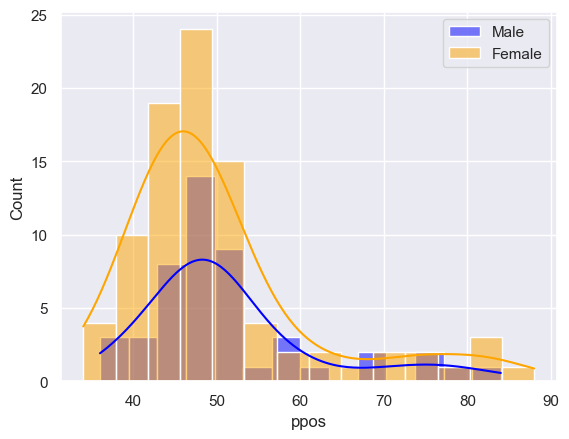

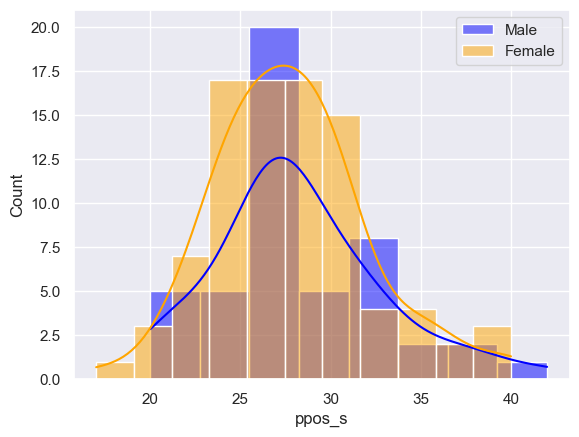

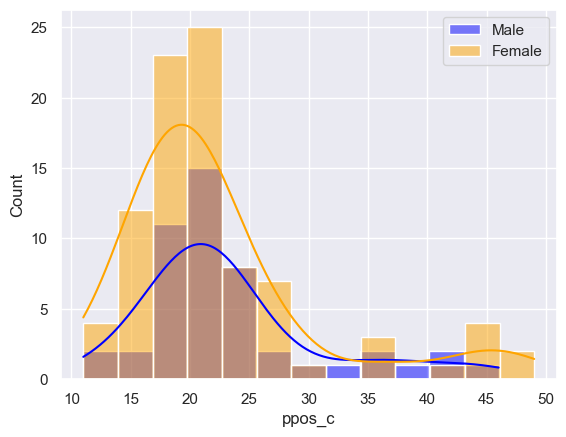

In [266]:
# Visualize score distributions by gender for normality/skewness
sns.histplot(df['ppos'][df['gender'] == 'Male'], kde=True, color='blue', label='Male')
sns.histplot(df['ppos'][df['gender'] == 'Female'], kde=True, color='orange', label='Female')
plt.legend()
plt.show()

sns.histplot(df['ppos_s'][df['gender'] == 'Male'], kde=True, color='blue', label='Male')
sns.histplot(df['ppos_s'][df['gender'] == 'Female'], kde=True, color='orange', label='Female')
plt.legend()
plt.show()

sns.histplot(df['ppos_c'][df['gender'] == 'Male'], kde=True, color='blue', label='Male')
sns.histplot(df['ppos_c'][df['gender'] == 'Female'], kde=True, color='orange', label='Female')
plt.legend()
plt.show()

### Statistical testing to check for skewness

We assess the distribution of PPOS and its subscales (PPOS, PPOS-S, PPOS-C) by calculating the skewness and performing a skewness test (`scipy.stats.skewtest`).  
- **Skewness** quantifies the asymmetry of the distribution: values close to 0 indicate symmetry, positive values indicate right skew, and negative values indicate left skew.
- **Skewness test** provides a p-value to test if the distribution is significantly skewed (null hypothesis: the distribution is symmetric).

This helps determine whether parametric or non-parametric statistical tests are appropriate for further group comparisons.

In [267]:

# # Calculate and test skewness for gender groups
# male_scores = df['ppos'][df['gender'] == 'Male'].dropna()
# female_scores = df['ppos'][df['gender'] == 'Female'].dropna()

# print("Male skewness:", skew(male_scores))
# print("Female skewness:", skew(female_scores))

# stat_male, p_male = skewtest(male_scores)
# stat_female, p_female = skewtest(female_scores)

# print(f"Male skew test: statistic={stat_male:.2f}, p={p_male:.3f}")
# print(f"Female skew test: statistic={stat_female:.2f}, p={p_female:.3f}")

# Skewness testing for PPOS, PPOS_S, PPOS_C columns overall
for col in ["ppos", "ppos_s", "ppos_c"]:
    scores = df[col].dropna()
    sk = skew(scores)
    stat, p = skewtest(scores)
    print(f"{col.upper()} skewness: {sk:.3f}")
    print(f"{col.upper()} skew test: statistic={stat:.2f}, p={p:.3g}")

PPOS skewness: 1.553
PPOS skew test: statistic=5.90, p=3.56e-09
PPOS_S skewness: 0.617
PPOS_S skew test: statistic=2.89, p=0.00382
PPOS_C skewness: 1.616
PPOS_C skew test: statistic=6.06, p=1.37e-09


In [268]:
### Hypothesis testing for PPOS scores and subscales by Gender

In [269]:
# Mann-Whitney U and t-tests for gender differences
# Statistical tests for gender differences in PPOS and subscales

# PPOS: Mann-Whitney U test
male_scores = df['ppos'][df['gender'] == 'Male']
female_scores = df['ppos'][df['gender'] == 'Female']
u_stat, p_val = mannwhitneyu(male_scores, female_scores, alternative='two-sided')
print("PPOS (Mann-Whitney U test)")
print(f"U statistic: {u_stat:.2f}")
print(f"p-value: {p_val:.3f}\n")

# PPOS-S: t-test
male_scores = df['ppos_s'][df['gender'] == 'Male'].dropna()
female_scores = df['ppos_s'][df['gender'] == 'Female'].dropna()
t_stat, p_val = ttest_ind(male_scores, female_scores, nan_policy='omit')
print("PPOS-S (t-test)")
print(f"t statistic: {t_stat:.2f}")
print(f"p-value: {p_val:.3f}\n")

# PPOS-C: Mann-Whitney U test
male_scores = df['ppos_c'][df['gender'] == 'Male'].dropna()
female_scores = df['ppos_c'][df['gender'] == 'Female'].dropna()
u_stat, p_val = mannwhitneyu(male_scores, female_scores, alternative='two-sided')
print("PPOS-C (Mann-Whitney U test)")
print(f"U statistic: {u_stat:.2f}")
print(f"p-value: {p_val:.3f}")

PPOS (Mann-Whitney U test)
U statistic: 2492.00
p-value: 0.138

PPOS-S (t-test)
t statistic: 0.52
p-value: 0.604

PPOS-C (Mann-Whitney U test)
U statistic: 2516.00
p-value: 0.111


### Statistical Comparison of PPOS and Subscales by Highest Degree

We test for differences in PPOS and subscale scores (PPOS, PPOS-S, PPOS-C) across groups defined by highest degree obtained.  
- **Kruskal-Wallis test** is used for non-normal data.  
- **ANOVA** is used for approximately normal data.

In [270]:
# PPOS: Kruskal-Wallis test
education_scores = [df['ppos'][df['highest_degree'] == tp] for tp in df['highest_degree'].unique()]
h_stat, p_val = kruskal(*education_scores)
print("PPOS (Kruskal-Wallis test by degree)")
print(f"  H statistic: {h_stat:.2f}")
print(f"  p-value: {p_val:.3f}\n")

# PPOS-S: ANOVA
education_scores = [df['ppos_s'][df['highest_degree'] == tp] for tp in df['highest_degree'].unique()]
f_stat, p_val = f_oneway(*education_scores)
print("PPOS-S (ANOVA by degree)")
print(f"  F statistic: {f_stat:.2f}")
print(f"  p-value: {p_val:.3f}\n")

# PPOS-C: Kruskal-Wallis test
education_scores = [df['ppos_c'][df['highest_degree'] == tp] for tp in df['highest_degree'].unique()]
h_stat, p_val = kruskal(*education_scores)
print("PPOS-C (Kruskal-Wallis test by degree)")
print(f"  H statistic: {h_stat:.2f}")
print(f"  p-value: {p_val:.3f}")

PPOS (Kruskal-Wallis test by degree)
  H statistic: 0.98
  p-value: 0.806

PPOS-S (ANOVA by degree)
  F statistic: 0.07
  p-value: 0.976

PPOS-C (Kruskal-Wallis test by degree)
  H statistic: 1.94
  p-value: 0.586


### Primary vs non-primary testing

We compare PPOS and subscale scores between primary care and non-primary care groups using Mann-Whitney U tests.

In [271]:
# Statistical comparison of PPOS and subscales: Primary Care vs Non-Primary Care (Mann-Whitney U tests)

# PPOS
primary_scores = df.loc[df['primary_care'], 'ppos']
non_primary_scores = df.loc[df['non_primary_care'], 'ppos']
u_stat, p_val = mannwhitneyu(primary_scores, non_primary_scores)
print("PPOS (Mann-Whitney U test: Primary vs Non-Primary Care)")
print(f"  U statistic: {u_stat:.2f}")
print(f"  p-value: {p_val:.3f}\n")

# PPOS-S
primary_scores = df.loc[df['primary_care'], 'ppos_s']
non_primary_scores = df.loc[df['non_primary_care'], 'ppos_s']
t_stat, p_val = ttest_ind(primary_scores, non_primary_scores)
print("PPOS-S (T-Test test: Primary vs Non-Primary Care)")
print(f"  t statistic: {t_stat:.2f}")
print(f"  p-value: {p_val:.3f}\n")

# PPOS-C
primary_scores = df.loc[df['primary_care'], 'ppos_c']
non_primary_scores = df.loc[df['non_primary_care'], 'ppos_c']
u_stat, p_val = mannwhitneyu(primary_scores, non_primary_scores)
print("PPOS-C (Mann-Whitney U test: Primary vs Non-Primary Care)")
print(f"  U statistic: {u_stat:.2f}")
print(f"  p-value: {p_val:.3f}")

PPOS (Mann-Whitney U test: Primary vs Non-Primary Care)
  U statistic: 618.50
  p-value: 0.407

PPOS-S (T-Test test: Primary vs Non-Primary Care)
  t statistic: -0.32
  p-value: 0.747

PPOS-C (Mann-Whitney U test: Primary vs Non-Primary Care)
  U statistic: 499.00
  p-value: 0.042


### Surgical vs non-surgical testing

We compare PPOS and subscale scores between surgical and non-surgical groups using Mann-Whitney U tests.

In [272]:
surgical_scores = df.loc[df['surgical'], 'ppos']
non_surgical_scores = df.loc[df['non_surgical'], 'ppos']

u_stat, p_val = mannwhitneyu(surgical_scores, non_surgical_scores)
print(f"Mann-Whitney for PPOS U: U={u_stat:.2f}, p={p_val:.3f}")

surgical_scores = df.loc[df['surgical'], 'ppos_s']
non_surgical_scores = df.loc[df['non_surgical'], 'ppos_s']

t_stat, p_val = ttest_ind(surgical_scores, non_surgical_scores)
print(f"t-test for PPOS_S: U={t_stat:.2f}, p={p_val:.3f}")

surgical_scores = df.loc[df['surgical'], 'ppos_c']
non_surgical_scores = df.loc[df['non_surgical'], 'ppos_c']

u_stat, p_val = mannwhitneyu(surgical_scores, non_surgical_scores)
print(f"Mann-Whitney for PPOS_C U: U={u_stat:.2f}, p={p_val:.3f}")

Mann-Whitney for PPOS U: U=685.00, p=0.505
t-test for PPOS_S: U=0.32, p=0.748
Mann-Whitney for PPOS_C U: U=666.00, p=0.640


# Summary
Based on these tests, the data appear to be significantly similar; there is no statistical difference between groups.Based on these test the data appears to be significantly similar, there is no statistical diference between groups

## 17. Export Cleaned Data

Export the cleaned dataset for reproducibility and further analysis.

In [273]:
df.to_excel(excel_writer="cleaned_data.xlsx", index=False)